# Packages

In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

## TensorFlow Packages (Basics)

In [2]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Set Up

In [6]:
data_dir = r"C:\Users\gdlar\Downloads\Files\Binary_Split\Data"
batch_size = 32; #standard batch size, can change as we move along
img_height = 150; #may need to change based on model used (alter at model generation?)
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
) 

Found 76391 files belonging to 2 classes.
Using 61113 files for training.
Found 76391 files belonging to 2 classes.
Using 15278 files for validation.


In [6]:
data_dir = r"C:\Users\gdlar\Downloads\Files\Binary_Split\Data"
# batch_size = 32; #standard batch size, can change as we move along
img_height = 224; #may need to change based on model used (alter at model generation?)
img_width = 224;
n_classes = 3

# Training Dataset
train_ds_10 = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = 5
)

# Validation Dataset
validation_ds_10 = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = 5
) 

Found 76391 files belonging to 2 classes.
Using 61113 files for training.
Found 76391 files belonging to 2 classes.
Using 15278 files for validation.


In [7]:
size = (224, 224)

train_ds_res1 = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds_res1 = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

## Data Augmentation

In [8]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = tf.keras.Sequential(
    [
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(0.1)
    ]
)
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
aug_ds1 = aug_ds.map(lambda x, y: (tf.image.resize(x, size), y))

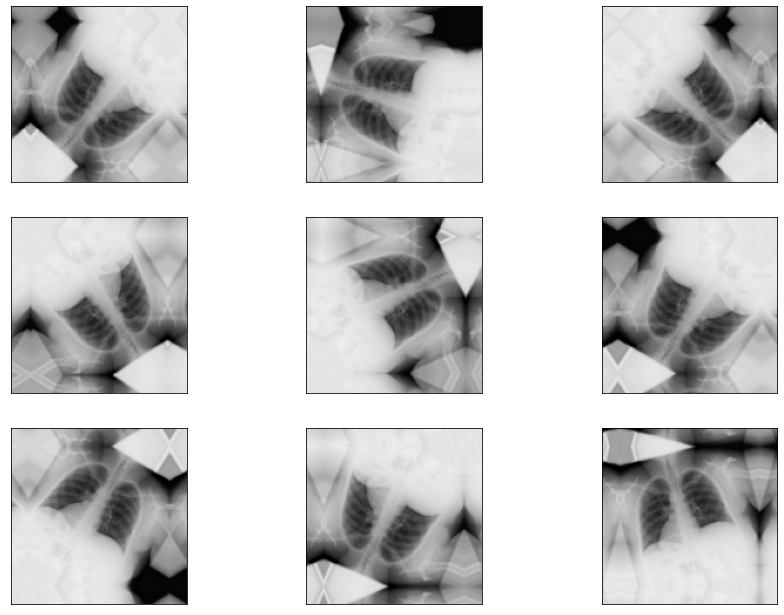

In [10]:
data_augmentation =Sequential()
# data_augmentation.add(layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)))
data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))
data_augmentation.add(layers.RandomRotation(0.2,fill_mode='nearest'))
# data_augmentation.add(layers.RandomRotation(0.2))
data_augmentation.add(layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')) 


plt.figure(figsize=[15,11])
for image, label in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(image) 
        plt.subplot(3, 3, i + 1, xticks=[],yticks=[])
        plt.imshow(augmented_images[0].numpy().astype("uint8"))        
plt.show()

aug_ds_2 = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

aug_ds_res2 = aug_ds_2.map(lambda x, y: (tf.image.resize(x, size), y))

## Metrics

In [11]:
metrics = ['AUC', 'accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TrueNegatives']

# Resnet 50

## Model 1

In [18]:
keras.backend.clear_session()

In [19]:
base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', pooling = 'max')

In [20]:
model = tf.keras.Sequential()
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
model.add(base_model)
model.add(Dense(512, activation="relu"))
model.add(Dense(1,activation='sigmoid'))

In [21]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001) # around 30%
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01) # around 34%
# optimizer = tf.keras.optimizers.Adadelta() # around 37%
# optimizer = tf.keras.optimizers.RMSprop() # around 40%
# optimizer = tf.keras.optimizers.RMSprop(momentum = 0.9, learning_rate=0.001) # around 50%



model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TrueNegatives'])

model.fit(train_ds_res1, validation_data = validation_ds_res1, 
                  steps_per_epoch = 50, 
                  epochs = 5) 

Epoch 1/5
50/50 [==============================] - 42s 671ms/step - loss: 0.6931 - auc: 0.5305 - accuracy: 0.5013 - precision: 0.6250 - recall: 0.1474 - false_negatives: 723.0000 - true_negatives: 677.0000 - val_loss: 0.6933 - val_auc: 0.5074 - val_accuracy: 0.4975 - val_precision: 0.5679 - val_recall: 0.2032 - val_false_negatives: 6429.0000 - val_true_negatives: 5961.0000
Epoch 2/5
50/50 [==============================] - 32s 646ms/step - loss: 0.6933 - auc: 0.5010 - accuracy: 0.4856 - precision: 0.5582 - recall: 0.2695 - false_negatives: 637.0000 - true_negatives: 542.0000 - val_loss: 0.6931 - val_auc: 0.5067 - val_accuracy: 0.5109 - val_precision: 0.5513 - val_recall: 0.3971 - val_false_negatives: 4865.0000 - val_true_negatives: 4601.0000
Epoch 3/5
50/50 [==============================] - 32s 644ms/step - loss: 0.6932 - auc: 0.5019 - accuracy: 0.5063 - precision: 0.5518 - recall: 0.5011 - false_negatives: 435.0000 - true_negatives: 373.0000 - val_loss: 0.6930 - val_auc: 0.5119 - val

## Model 3

In [23]:
keras.backend.clear_session()

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, decay = 0.01) # around 30%
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01) # around 34%
# optimizer = tf.keras.optimizers.Adadelta() # around 37%
# optimizer = tf.keras.optimizers.RMSprop() # around 40%
# optimizer = tf.keras.optimizers.RMSprop(momentum = 0.9, learning_rate=0.001) # around 50%



model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=metrics)

model.fit(train_ds_res1, validation_data = validation_ds_res1, steps_per_epoch = 50, 
                  epochs = 5) 

Epoch 1/5
50/50 [==============================] - 39s 724ms/step - loss: 0.6916 - auc: 0.5041 - accuracy: 0.5275 - precision: 0.5316 - recall: 0.9377 - false_negatives: 53.0000 - true_negatives: 46.0000 - val_loss: 0.6882 - val_auc: 0.6003 - val_accuracy: 0.5280 - val_precision: 0.5281 - val_recall: 0.9998 - val_false_negatives: 2.0000 - val_true_negatives: 0.0000e+00
Epoch 2/5
50/50 [==============================] - 39s 790ms/step - loss: 0.6892 - auc: 0.5214 - accuracy: 0.5369 - precision: 0.5493 - recall: 0.8253 - false_negatives: 152.0000 - true_negatives: 141.0000 - val_loss: 0.6885 - val_auc: 0.6001 - val_accuracy: 0.5281 - val_precision: 0.5281 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 3/5
50/50 [==============================] - 37s 758ms/step - loss: 0.6838 - auc: 0.5967 - accuracy: 0.5419 - precision: 0.5415 - recall: 0.9768 - false_negatives: 20.0000 - true_negatives: 25.0000 - val_loss: 0.6882 - val_auc: 0.6018 - val_acc

# VGG19

## Model 3

In [12]:
keras.backend.clear_session()
#size is same as ResNet
base_model = tf.keras.applications.VGG19(
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='None',
)

In [13]:
for layer in base_model.layers:
    layer.trainable = False


model = keras.models.Sequential()
model.add(base_model)
model.add(Dense(512, activation="relu"))
model.add(Dense(1,activation='sigmoid'))

In [14]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001) # around 40%
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=metrics)

model.fit(train_ds_res1, 
                  validation_data = validation_ds_res1,
                  steps_per_epoch = 50,
                  # batch_size = 128,
                  epochs = 5) 

Epoch 1/5
50/50 [==============================] - 44s 758ms/step - loss: 0.6914 - auc: 0.5719 - accuracy: 0.5362 - precision: 0.5342 - recall: 0.9515 - false_negatives: 41.0000 - true_negatives: 54.0000 - val_loss: 0.6898 - val_auc: 0.6365 - val_accuracy: 0.5491 - val_precision: 0.5406 - val_recall: 0.9745 - val_false_negatives: 206.0000 - val_true_negatives: 526.0000
Epoch 2/5
50/50 [==============================] - 37s 747ms/step - loss: 0.6877 - auc: 0.6332 - accuracy: 0.5700 - precision: 0.5616 - recall: 0.9540 - false_negatives: 40.0000 - true_negatives: 82.0000 - val_loss: 0.6870 - val_auc: 0.6515 - val_accuracy: 0.5341 - val_precision: 0.5316 - val_recall: 0.9910 - val_false_negatives: 73.0000 - val_true_negatives: 164.0000
Epoch 3/5
50/50 [==============================] - 37s 757ms/step - loss: 0.6843 - auc: 0.6533 - accuracy: 0.5556 - precision: 0.5506 - recall: 0.9885 - false_negatives: 10.0000 - true_negatives: 30.0000 - val_loss: 0.6844 - val_auc: 0.6536 - val_accuracy: 

## Model 4

In [20]:
keras.backend.clear_session()
#size is same as ResNet
base_model = tf.keras.applications.VGG19(
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='None',
)

In [21]:
for layer in base_model.layers:
    layer.trainable = False


model = keras.models.Sequential()
model.add(base_model)
model.add(Dense(512, activation="relu"))
model.add(Dense(1,activation='sigmoid'))

In [22]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001) # around 40%
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=metrics)

model.fit(aug_ds_res2, 
                  validation_data = validation_ds_res1,
                  steps_per_epoch = 50,
                  # batch_size = 128,
                  epochs = 5) 

Epoch 1/5
50/50 [==============================] - 45s 885ms/step - loss: 0.6926 - auc: 0.5200 - accuracy: 0.5269 - precision: 0.5331 - recall: 0.8632 - false_negatives: 116.0000 - true_negatives: 111.0000 - val_loss: 0.6918 - val_auc: 0.5354 - val_accuracy: 0.5437 - val_precision: 0.5392 - val_recall: 0.9359 - val_false_negatives: 517.0000 - val_true_negatives: 755.0000
Epoch 2/5
50/50 [==============================] - 39s 797ms/step - loss: 0.6898 - auc: 0.5869 - accuracy: 0.5525 - precision: 0.5523 - recall: 0.9943 - false_negatives: 5.0000 - true_negatives: 7.0000 - val_loss: 0.6902 - val_auc: 0.5690 - val_accuracy: 0.5353 - val_precision: 0.5329 - val_recall: 0.9737 - val_false_negatives: 212.0000 - val_true_negatives: 322.0000
Epoch 3/5
50/50 [==============================] - 39s 800ms/step - loss: 0.6893 - auc: 0.5578 - accuracy: 0.5431 - precision: 0.5429 - recall: 0.9988 - false_negatives: 1.0000 - true_negatives: 2.0000 - val_loss: 0.6894 - val_auc: 0.5864 - val_accuracy: 0

# VGG16

## Model 1

In [15]:
keras.backend.clear_session()

In [16]:
base_model = tf.keras.applications.VGG16(
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='None',
)

In [17]:
for layer in base_model.layers:
    layer.trainable = False


model = keras.models.Sequential()
model.add(base_model)
model.add(Dense(512, activation="relu"))
model.add(Dense(1,activation='sigmoid'))

In [18]:
# for layer in base_model.layers:
#     layer.trainable = True

# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, decay = 0.01) # around 30%
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01) # around 34%
# optimizer = tf.keras.optimizers.Adadelta() # around 37%
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001) # around 40%
# optimizer = tf.keras.optimizers.RMSprop(momentum = 0.9, learning_rate=0.001) # around 50%


model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=metrics)

model.fit(train_ds_res1, 
                  validation_data = validation_ds_res1,
                  steps_per_epoch = 50,
                  # batch_size = 128,
                  epochs = 5) 

Epoch 1/5
50/50 [==============================] - 34s 663ms/step - loss: 0.6921 - auc: 0.5459 - accuracy: 0.5269 - precision: 0.5381 - recall: 0.7349 - false_negatives: 224.0000 - true_negatives: 222.0000 - val_loss: 0.6908 - val_auc: 0.6094 - val_accuracy: 0.5610 - val_precision: 0.5525 - val_recall: 0.8888 - val_false_negatives: 897.0000 - val_true_negatives: 1399.0000
Epoch 2/5
50/50 [==============================] - 32s 645ms/step - loss: 0.6889 - auc: 0.5842 - accuracy: 0.5738 - precision: 0.5724 - recall: 0.9270 - false_negatives: 65.0000 - true_negatives: 92.0000 - val_loss: 0.6888 - val_auc: 0.6248 - val_accuracy: 0.5289 - val_precision: 0.5286 - val_recall: 0.9973 - val_false_negatives: 22.0000 - val_true_negatives: 33.0000
Epoch 3/5
50/50 [==============================] - 31s 633ms/step - loss: 0.6866 - auc: 0.6394 - accuracy: 0.5469 - precision: 0.5430 - recall: 0.9965 - false_negatives: 3.0000 - true_negatives: 17.0000 - val_loss: 0.6869 - val_auc: 0.6309 - val_accuracy:

## Model 3

In [19]:
keras.backend.clear_session()

base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = keras.layers.Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = metrics)
vgghist = model.fit(train_ds_res1,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 32s 617ms/step - loss: 4.8169 - auc: 0.6121 - accuracy: 0.6000 - precision: 0.6201 - recall: 0.6171 - false_negatives: 322.0000 - true_negatives: 441.0000 - val_loss: 1.1816 - val_auc: 0.7181 - val_accuracy: 0.6625 - val_precision: 0.6880 - val_recall: 0.6607 - val_false_negatives: 2738.0000 - val_true_negatives: 4791.0000
Epoch 2/5
50/50 [==============================] - 30s 602ms/step - loss: 1.2419 - auc: 0.6726 - accuracy: 0.6200 - precision: 0.6523 - recall: 0.6568 - false_negatives: 301.0000 - true_negatives: 416.0000 - val_loss: 0.7089 - val_auc: 0.7321 - val_accuracy: 0.6644 - val_precision: 0.6630 - val_recall: 0.7411 - val_false_negatives: 2089.0000 - val_true_negatives: 4170.0000
Epoch 3/5
50/50 [==============================] - 30s 605ms/step - loss: 0.8400 - auc: 0.6834 - accuracy: 0.6212 - precision: 0.6521 - recall: 0.6640 - false_negatives: 295.0000 - true_negatives: 411.0000 - val_loss: 0.6509 - val_auc: 0.7464 - val

## Model 3a

In [24]:
keras.backend.clear_session()

base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = keras.layers.Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = metrics)
vgghist = model.fit(train_ds_res1,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 34s 636ms/step - loss: 4.7943 - auc: 0.6098 - accuracy: 0.5969 - precision: 0.6228 - recall: 0.6118 - false_negatives: 330.0000 - true_negatives: 435.0000 - val_loss: 1.0364 - val_auc: 0.7106 - val_accuracy: 0.6436 - val_precision: 0.6353 - val_recall: 0.7634 - val_false_negatives: 1909.0000 - val_true_negatives: 3673.0000
Epoch 2/5
50/50 [==============================] - 30s 617ms/step - loss: 1.2098 - auc: 0.6480 - accuracy: 0.6056 - precision: 0.6379 - recall: 0.6488 - false_negatives: 308.0000 - true_negatives: 400.0000 - val_loss: 0.7564 - val_auc: 0.7257 - val_accuracy: 0.6477 - val_precision: 0.6326 - val_recall: 0.7942 - val_false_negatives: 1661.0000 - val_true_negatives: 3487.0000
Epoch 3/5
50/50 [==============================] - 34s 691ms/step - loss: 0.8272 - auc: 0.6910 - accuracy: 0.6344 - precision: 0.6633 - recall: 0.6716 - false_negatives: 287.0000 - true_negatives: 428.0000 - val_loss: 0.6709 - val_auc: 0.7369 - val

## Model 4 - Augmented

In [25]:
keras.backend.clear_session()

In [30]:
keras.backend.clear_session()

base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = keras.layers.Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = metrics)
model.fit(aug_ds1,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 34s 654ms/step - loss: 4.8372 - auc: 0.5894 - accuracy: 0.5738 - precision: 0.5981 - recall: 0.5995 - false_negatives: 340.0000 - true_negatives: 409.0000 - val_loss: 2.7580 - val_auc: 0.6810 - val_accuracy: 0.5893 - val_precision: 0.8197 - val_recall: 0.2850 - val_false_negatives: 5769.0000 - val_true_negatives: 6703.0000
Epoch 2/5
50/50 [==============================] - 31s 623ms/step - loss: 1.5454 - auc: 0.6466 - accuracy: 0.6156 - precision: 0.6498 - recall: 0.6446 - false_negatives: 311.0000 - true_negatives: 421.0000 - val_loss: 0.9150 - val_auc: 0.6852 - val_accuracy: 0.6286 - val_precision: 0.6251 - val_recall: 0.7417 - val_false_negatives: 2084.0000 - val_true_negatives: 3619.0000
Epoch 3/5
50/50 [==============================] - 34s 701ms/step - loss: 0.9896 - auc: 0.6534 - accuracy: 0.6144 - precision: 0.6452 - recall: 0.6606 - false_negatives: 298.0000 - true_negatives: 403.0000 - val_loss: 0.6865 - val_auc: 0.6963 - val

In [32]:
keras.backend.clear_session()

## Model 5

In [33]:
keras.backend.clear_session()

# base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False)
for layer in base_model.layers:
    layer.trainable = False
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = keras.layers.Dropout(0.7)(x)
# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = metrics)
model.fit(aug_ds_res2,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 38s 729ms/step - loss: 5.9237 - auc: 0.5711 - accuracy: 0.5575 - precision: 0.5862 - recall: 0.5780 - false_negatives: 360.0000 - true_negatives: 399.0000 - val_loss: 1.7773 - val_auc: 0.6626 - val_accuracy: 0.6280 - val_precision: 0.6482 - val_recall: 0.6464 - val_false_negatives: 2853.0000 - val_true_negatives: 4378.0000
Epoch 2/5
50/50 [==============================] - 34s 685ms/step - loss: 2.5116 - auc: 0.6180 - accuracy: 0.5938 - precision: 0.6253 - recall: 0.6310 - false_negatives: 321.0000 - true_negatives: 401.0000 - val_loss: 1.4099 - val_auc: 0.6512 - val_accuracy: 0.6030 - val_precision: 0.5914 - val_recall: 0.8033 - val_false_negatives: 1587.0000 - val_true_negatives: 2730.0000
Epoch 3/5
50/50 [==============================] - 34s 693ms/step - loss: 1.4758 - auc: 0.6064 - accuracy: 0.5844 - precision: 0.6186 - recall: 0.6306 - false_negatives: 324.0000 - true_negatives: 382.0000 - val_loss: 0.9651 - val_auc: 0.6761 - val

# InceptionV3

## Model 1

In [38]:
tf.keras.backend.clear_session()

In [39]:
tf.keras.backend.clear_session()
from keras.applications.inception_v3 import InceptionV3
# from keras.preprocessing import image
# from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
# create the base pre-trained model
base_model = InceptionV3(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum = 0.9)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
# train the model on the new data for a few epochs
model.fit(train_ds_res1,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 42s 735ms/step - loss: 1.7493 - auc: 0.5191 - accuracy: 0.5331 - precision: 0.5500 - recall: 0.6545 - false_negatives: 293.0000 - true_negatives: 298.0000 - val_loss: 2279.6072 - val_auc: 0.5000 - val_accuracy: 0.5281 - val_precision: 0.5281 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 2/5
50/50 [==============================] - 37s 752ms/step - loss: 0.6995 - auc: 0.5608 - accuracy: 0.5775 - precision: 0.5876 - recall: 0.7773 - false_negatives: 196.0000 - true_negatives: 240.0000 - val_loss: 6.6965 - val_auc: 0.5042 - val_accuracy: 0.4746 - val_precision: 0.5665 - val_recall: 0.0222 - val_false_negatives: 7890.0000 - val_true_negatives: 7072.0000
Epoch 3/5
50/50 [==============================] - 36s 724ms/step - loss: 0.6761 - auc: 0.6348 - accuracy: 0.6219 - precision: 0.6282 - recall: 0.7445 - false_negatives: 222.0000 - true_negatives: 348.0000 - val_loss: 1.1852 - val_auc: 0.5177 

## Model 4 - Augmented

In [41]:
tf.keras.backend.clear_session()

In [42]:

base_model = InceptionV3(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')

x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum = 0.9)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
# train the model on the new data for a few epochs
model.fit(aug_ds1,
            steps_per_epoch=50,
            validation_data=validation_ds_res1,
            epochs=5)

Epoch 1/5
50/50 [==============================] - 41s 724ms/step - loss: 1.8263 - auc: 0.4992 - accuracy: 0.4975 - precision: 0.5145 - recall: 0.5542 - false_negatives: 370.0000 - true_negatives: 336.0000 - val_loss: 51892.2500 - val_auc: 0.5000 - val_accuracy: 0.5281 - val_precision: 0.5281 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 2/5
50/50 [==============================] - 34s 694ms/step - loss: 0.8271 - auc: 0.4768 - accuracy: 0.5394 - precision: 0.5581 - recall: 0.8434 - false_negatives: 140.0000 - true_negatives: 109.0000 - val_loss: 845.9750 - val_auc: 0.5049 - val_accuracy: 0.4768 - val_precision: 0.7065 - val_recall: 0.0161 - val_false_negatives: 7939.0000 - val_true_negatives: 7155.0000
Epoch 3/5
50/50 [==============================] - 34s 692ms/step - loss: 0.7220 - auc: 0.5138 - accuracy: 0.5344 - precision: 0.5467 - recall: 0.8414 - false_negatives: 138.0000 - true_negatives: 123.0000 - val_loss: 4467.1758 - val_auc: 0

# DenseNet201

## Model 1

In [23]:
tf.keras.backend.clear_session()
base_model = tf.keras.applications.DenseNet201(weights="imagenet", include_top=False, input_shape=(224,224,3), pooling='max')

In [24]:
for layer in base_model.layers:
    layer.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [25]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001) # around 

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [27]:
model.fit(aug_ds_res2, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds_res1)

Epoch 1/5
50/50 [==============================] - 60s 1s/step - loss: 3.3851 - auc: 0.5133 - accuracy: 0.5088 - precision: 0.5326 - recall: 0.5339 - false_negatives: 392.0000 - true_negatives: 365.0000 - val_loss: 1.0161 - val_auc: 0.5739 - val_accuracy: 0.5528 - val_precision: 0.5609 - val_recall: 0.7058 - val_false_negatives: 2374.0000 - val_true_negatives: 2750.0000
Epoch 2/5
50/50 [==============================] - 54s 1s/step - loss: 2.3731 - auc: 0.5274 - accuracy: 0.5225 - precision: 0.5656 - recall: 0.5682 - false_negatives: 380.0000 - true_negatives: 336.0000 - val_loss: 0.9256 - val_auc: 0.5918 - val_accuracy: 0.5634 - val_precision: 0.6077 - val_recall: 0.4893 - val_false_negatives: 4121.0000 - val_true_negatives: 4660.0000
Epoch 3/5
50/50 [==============================] - 54s 1s/step - loss: 1.6676 - auc: 0.5350 - accuracy: 0.5312 - precision: 0.5739 - recall: 0.5700 - false_negatives: 378.0000 - true_negatives: 349.0000 - val_loss: 0.9725 - val_auc: 0.5644 - val_accuracy

## Model 6

In [48]:
tf.keras.backend.clear_session()

In [51]:
base_model = tf.keras.applications.DenseNet201(weights="imagenet", include_top=False, input_shape=(224,224,3))

In [52]:
for layer in base_model.layers:
    layer.trainable = False

v_model = keras.models.Sequential()
v_model.add(base_model)
v_model.add(keras.layers.Flatten())
v_model.add(Dense(512, activation="relu"))
v_model.add(keras.layers.Dropout(0.5))
v_model.add(Dense(1,activation='sigmoid'))

In [63]:
v_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 512)               48169472  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 66,491,969
Trainable params: 48,169,985
Non-trainable params: 18,321,984
_________________________________________________________________


In [53]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) # around 

v_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [54]:
v_model.fit(train_ds_res1, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds_res1)

Epoch 1/5
50/50 [==============================] - 83s 2s/step - loss: 60.8571 - auc: 0.5610 - accuracy: 0.5575 - precision: 0.5790 - recall: 0.5721 - false_negatives: 359.0000 - true_negatives: 412.0000 - val_loss: 20.1818 - val_auc: 0.5227 - val_accuracy: 0.5405 - val_precision: 0.5354 - val_recall: 0.9836 - val_false_negatives: 132.0000 - val_true_negatives: 321.0000
Epoch 2/5
50/50 [==============================] - 71s 1s/step - loss: 9.8640 - auc: 0.5721 - accuracy: 0.5725 - precision: 0.6114 - recall: 0.6210 - false_negatives: 335.0000 - true_negatives: 367.0000 - val_loss: 0.8708 - val_auc: 0.6194 - val_accuracy: 0.5410 - val_precision: 0.5361 - val_recall: 0.9716 - val_false_negatives: 229.0000 - val_true_negatives: 426.0000
Epoch 3/5
50/50 [==============================] - 71s 1s/step - loss: 1.1412 - auc: 0.5980 - accuracy: 0.5788 - precision: 0.6070 - recall: 0.6663 - false_negatives: 294.0000 - true_negatives: 339.0000 - val_loss: 0.6494 - val_auc: 0.6661 - val_accuracy: 

# Xception

## Model 1

In [59]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [64]:
for layer in base_model.layers:
    layer.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) # around 

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 72,242,729
Trainable params: 51,381,249
Non-trainable params: 20,861,480
_________________________________________________________________


In [66]:
model.fit(aug_ds1, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds_res1)

Epoch 1/5
50/50 [==============================] - 40s 732ms/step - loss: 418.1561 - auc: 0.4990 - accuracy: 0.5006 - precision: 0.5297 - recall: 0.5153 - false_negatives: 411.0000 - true_negatives: 364.0000 - val_loss: 7.9080 - val_auc: 0.6363 - val_accuracy: 0.6227 - val_precision: 0.6270 - val_recall: 0.7048 - val_false_negatives: 2382.0000 - val_true_negatives: 3826.0000
Epoch 2/5
50/50 [==============================] - 34s 686ms/step - loss: 28.1378 - auc: 0.5331 - accuracy: 0.5356 - precision: 0.5764 - recall: 0.5652 - false_negatives: 380.0000 - true_negatives: 363.0000 - val_loss: 14.3144 - val_auc: 0.5885 - val_accuracy: 0.5475 - val_precision: 0.8074 - val_recall: 0.1881 - val_false_negatives: 6551.0000 - val_true_negatives: 6847.0000
Epoch 3/5
50/50 [==============================] - 34s 691ms/step - loss: 28.2222 - auc: 0.5432 - accuracy: 0.5437 - precision: 0.5826 - recall: 0.5706 - false_negatives: 374.0000 - true_negatives: 373.0000 - val_loss: 14.7909 - val_auc: 0.5401

## Model 2

In [67]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [70]:
for layer in base_model.layers:
    layer.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001, momentum = 0.9, decay = 0.01) # around 

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [71]:
model.fit(aug_ds1, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds_res1)

Epoch 1/5
50/50 [==============================] - 42s 795ms/step - loss: 3604.5054 - auc: 0.5408 - accuracy: 0.5431 - precision: 0.5703 - recall: 0.5763 - false_negatives: 361.0000 - true_negatives: 378.0000 - val_loss: 926.6154 - val_auc: 0.5454 - val_accuracy: 0.5214 - val_precision: 0.8194 - val_recall: 0.1203 - val_false_negatives: 7098.0000 - val_true_negatives: 6995.0000
Epoch 2/5
50/50 [==============================] - 34s 688ms/step - loss: 149.1305 - auc: 0.5479 - accuracy: 0.5244 - precision: 0.5771 - recall: 0.4649 - false_negatives: 465.0000 - true_negatives: 435.0000 - val_loss: 0.8204 - val_auc: 0.5558 - val_accuracy: 0.5700 - val_precision: 0.5621 - val_recall: 0.8409 - val_false_negatives: 1284.0000 - val_true_negatives: 1924.0000
Epoch 3/5
50/50 [==============================] - 34s 691ms/step - loss: 2.2901 - auc: 0.4916 - accuracy: 0.5469 - precision: 0.5490 - recall: 0.9496 - false_negatives: 44.0000 - true_negatives: 46.0000 - val_loss: 0.6907 - val_auc: 0.5028 

# Model 6

In [28]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [29]:
for layer in base_model.layers:
    layer.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001, momentum = 0.9, decay = 0.01) # around 

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [31]:
model.fit(train_ds_res1, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds_res1)

Epoch 1/5
50/50 [==============================] - 38s 707ms/step - loss: 4111.9556 - auc: 0.5522 - accuracy: 0.5544 - precision: 0.5749 - recall: 0.5919 - false_negatives: 344.0000 - true_negatives: 388.0000 - val_loss: 870.4650 - val_auc: 0.6412 - val_accuracy: 0.6405 - val_precision: 0.6692 - val_recall: 0.6316 - val_false_negatives: 2973.0000 - val_true_negatives: 4690.0000
Epoch 2/5
50/50 [==============================] - 34s 686ms/step - loss: 778.9586 - auc: 0.5676 - accuracy: 0.5713 - precision: 0.6129 - recall: 0.6032 - false_negatives: 350.0000 - true_negatives: 382.0000 - val_loss: 41.7607 - val_auc: 0.6370 - val_accuracy: 0.6291 - val_precision: 0.6788 - val_recall: 0.5650 - val_false_negatives: 3510.0000 - val_true_negatives: 5052.0000
Epoch 3/5
50/50 [==============================] - 34s 683ms/step - loss: 9.6883 - auc: 0.5153 - accuracy: 0.5356 - precision: 0.5520 - recall: 0.8107 - false_negatives: 166.0000 - true_negatives: 146.0000 - val_loss: 0.7832 - val_auc: 0.53

# Xception

## Model 6

In [9]:
tf.keras.backend.clear_session()

In [10]:
base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [11]:
for layer in base_model.layers:
    layer.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [12]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) # around 

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [13]:
model.fit(train_ds, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds)

Epoch 1/5
50/50 [==============================] - 40s 704ms/step - loss: 391.1012 - auc: 0.5273 - accuracy: 0.5281 - precision: 0.5562 - recall: 0.5529 - false_negatives: 380.0000 - true_negatives: 375.0000 - val_loss: 223.0313 - val_auc: 0.5000 - val_accuracy: 0.4719 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_negatives: 8069.0000 - val_true_negatives: 7209.0000
Epoch 2/5
50/50 [==============================] - 36s 724ms/step - loss: 78.0917 - auc: 0.5521 - accuracy: 0.5562 - precision: 0.5962 - recall: 0.5812 - false_negatives: 366.0000 - true_negatives: 382.0000 - val_loss: 22.5021 - val_auc: 0.6520 - val_accuracy: 0.6451 - val_precision: 0.6773 - val_recall: 0.6266 - val_false_negatives: 3013.0000 - val_true_negatives: 4800.0000
Epoch 3/5
50/50 [==============================] - 34s 690ms/step - loss: 56.3120 - auc: 0.5551 - accuracy: 0.5581 - precision: 0.5980 - recall: 0.6027 - false_negatives: 350.0000 - true_negatives: 362.0000 - val_loss: 25.5552 - val_a

# ResNet-152V2

In [14]:
tf.keras.backend.clear_session()
from keras.applications.resnet_v2 import ResNet152V2

base_model = ResNet152V2(input_shape=(224, 224,3), include_top=False, weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False

from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), loss = 'binary_crossentropy', metrics = metrics)

model.fit(aug_ds, validation_data = validation_ds, steps_per_epoch = 50, epochs = 5)

Epoch 1/5
50/50 [==============================] - 74s 1s/step - loss: 55259.7734 - auc: 0.5033 - accuracy: 0.4919 - precision: 0.5262 - recall: 0.3799 - false_negatives: 524.0000 - true_negatives: 466.0000 - val_loss: 0.7074 - val_auc: 0.4992 - val_accuracy: 0.5266 - val_precision: 0.5275 - val_recall: 0.9938 - val_false_negatives: 50.0000 - val_true_negatives: 27.0000
Epoch 2/5
50/50 [==============================] - 65s 1s/step - loss: 7.0687 - auc: 0.5110 - accuracy: 0.5469 - precision: 0.5463 - recall: 0.9828 - false_negatives: 15.0000 - true_negatives: 20.0000 - val_loss: 0.7010 - val_auc: 0.4995 - val_accuracy: 0.5274 - val_precision: 0.5279 - val_recall: 0.9960 - val_false_negatives: 32.0000 - val_true_negatives: 21.0000
Epoch 3/5
50/50 [==============================] - 65s 1s/step - loss: 1.0542 - auc: 0.5018 - accuracy: 0.5431 - precision: 0.5441 - recall: 0.9804 - false_negatives: 17.0000 - true_negatives: 17.0000 - val_loss: 0.7007 - val_auc: 0.4996 - val_accuracy: 0.5276

# DenseNet-121

In [14]:
tf.keras.backend.clear_session()
from keras.applications.densenet import DenseNet121
tf.keras.backend.clear_session()
base_model = DenseNet121(input_shape = (224, 224,3), include_top=False,weights='imagenet')

x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.7)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),loss='binary_crossentropy',metrics=metrics)

model.fit(train_ds,
                    steps_per_epoch=50,
                    validation_data=validation_ds,
                    epochs=5)


Epoch 1/5
50/50 [==============================] - 65s 993ms/step - loss: 1.5587 - auc: 0.5838 - accuracy: 0.5531 - precision: 0.5724 - recall: 0.6083 - false_negatives: 331.0000 - true_negatives: 371.0000 - val_loss: 0.6329 - val_auc: 0.6994 - val_accuracy: 0.6444 - val_precision: 0.6823 - val_recall: 0.6112 - val_false_negatives: 3137.0000 - val_true_negatives: 4913.0000
Epoch 2/5
50/50 [==============================] - 45s 906ms/step - loss: 0.7089 - auc: 0.6577 - accuracy: 0.6162 - precision: 0.6342 - recall: 0.6954 - false_negatives: 265.0000 - true_negatives: 381.0000 - val_loss: 0.6130 - val_auc: 0.7182 - val_accuracy: 0.6529 - val_precision: 0.6590 - val_recall: 0.7105 - val_false_negatives: 2336.0000 - val_true_negatives: 4242.0000
Epoch 3/5
50/50 [==============================] - 45s 905ms/step - loss: 0.6397 - auc: 0.7133 - accuracy: 0.6531 - precision: 0.6821 - recall: 0.6766 - false_negatives: 281.0000 - true_negatives: 457.0000 - val_loss: 0.6243 - val_auc: 0.7524 - val

# InceptionResNetV2

## Model 2

In [15]:
tf.keras.backend.clear_session()
# create the base pre-trained model
base_model = InceptionResNetV2(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = metrics)

# train the model on the new data for a few epochs
model.fit(train_ds,
                    steps_per_epoch=50,
                    validation_data=validation_ds,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 97s 2s/step - loss: 1.2197 - auc: 0.6060 - accuracy: 0.5863 - precision: 0.6055 - recall: 0.6213 - false_negatives: 320.0000 - true_negatives: 413.0000 - val_loss: 2.8838 - val_auc: 0.6541 - val_accuracy: 0.4775 - val_precision: 0.9143 - val_recall: 0.0119 - val_false_negatives: 7973.0000 - val_true_negatives: 7200.0000
Epoch 2/5
50/50 [==============================] - 72s 1s/step - loss: 0.7031 - auc: 0.6856 - accuracy: 0.6381 - precision: 0.6677 - recall: 0.6970 - false_negatives: 270.0000 - true_negatives: 400.0000 - val_loss: 0.6585 - val_auc: 0.7367 - val_accuracy: 0.6660 - val_precision: 0.7609 - val_recall: 0.5360 - val_false_negatives: 3744.0000 - val_true_negatives: 5850.0000
Epoch 3/5
50/50 [==============================] - 72s 1s/step - loss: 0.6393 - auc: 0.7223 - accuracy: 0.6606 - precision: 0.6978 - recall: 0.6516 - false_negatives: 300.0000 - true_negatives: 496.0000 - val_loss: 0.6964 - val_auc: 0.7619 - val_accuracy

## Model 3

In [16]:
# create the base pre-trained model
tf.keras.backend.clear_session()
base_model = InceptionResNetV2(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = metrics)

# train the model on the new data for a few epochs
model.fit(train_ds,
                    steps_per_epoch=50,
                    validation_data=validation_ds,
                    epochs=7)

Epoch 1/5
50/50 [==============================] - 104s 2s/step - loss: 0.8955 - auc: 0.5838 - accuracy: 0.5606 - precision: 0.5825 - recall: 0.5791 - false_negatives: 354.0000 - true_negatives: 410.0000 - val_loss: 0.6774 - val_auc: 0.7038 - val_accuracy: 0.6521 - val_precision: 0.6737 - val_recall: 0.6618 - val_false_negatives: 2729.0000 - val_true_negatives: 4623.0000
Epoch 2/5
50/50 [==============================] - 74s 1s/step - loss: 0.6864 - auc: 0.6679 - accuracy: 0.6313 - precision: 0.6538 - recall: 0.6956 - false_negatives: 267.0000 - true_negatives: 400.0000 - val_loss: 0.6644 - val_auc: 0.7364 - val_accuracy: 0.6757 - val_precision: 0.6926 - val_recall: 0.6940 - val_false_negatives: 2469.0000 - val_true_negatives: 4724.0000
Epoch 3/5
50/50 [==============================] - 73s 1s/step - loss: 0.6438 - auc: 0.7304 - accuracy: 0.6800 - precision: 0.7099 - recall: 0.7050 - false_negatives: 259.0000 - true_negatives: 469.0000 - val_loss: 0.8442 - val_auc: 0.7620 - val_accurac

## Model 4

In [11]:
# create the base pre-trained model
tf.keras.backend.clear_session()
base_model = InceptionResNetV2(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = metrics)

# train the model on the new data for a few epochs
model.fit(train_ds,
                    steps_per_epoch=50,
                    validation_data=validation_ds,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 85s 1s/step - loss: 0.8440 - auc: 0.5655 - accuracy: 0.5419 - precision: 0.5661 - recall: 0.5894 - false_negatives: 349.0000 - true_negatives: 366.0000 - val_loss: 0.6420 - val_auc: 0.6881 - val_accuracy: 0.6394 - val_precision: 0.6792 - val_recall: 0.6012 - val_false_negatives: 3218.0000 - val_true_negatives: 4918.0000
Epoch 2/5
50/50 [==============================] - 65s 1s/step - loss: 0.7172 - auc: 0.6305 - accuracy: 0.5969 - precision: 0.6257 - recall: 0.6522 - false_negatives: 304.0000 - true_negatives: 385.0000 - val_loss: 0.6271 - val_auc: 0.7154 - val_accuracy: 0.6524 - val_precision: 0.7273 - val_recall: 0.5469 - val_false_negatives: 3656.0000 - val_true_negatives: 5554.0000
Epoch 3/5
50/50 [==============================] - 66s 1s/step - loss: 0.6613 - auc: 0.6739 - accuracy: 0.6162 - precision: 0.6536 - recall: 0.6447 - false_negatives: 313.0000 - true_negatives: 418.0000 - val_loss: 0.5955 - val_auc: 0.7399 - val_accuracy

## Model 5

In [12]:

# create the base pre-trained model
tf.keras.backend.clear_session()
base_model = InceptionResNetV2(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.7)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = metrics)

# train the model on the new data for a few epochs
model.fit(train_ds,
                    steps_per_epoch=50,
                    validation_data=validation_ds,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 103s 2s/step - loss: 0.9006 - auc: 0.5490 - accuracy: 0.5381 - precision: 0.5597 - recall: 0.5882 - false_negatives: 348.0000 - true_negatives: 364.0000 - val_loss: 0.6510 - val_auc: 0.6949 - val_accuracy: 0.6423 - val_precision: 0.6897 - val_recall: 0.5867 - val_false_negatives: 3335.0000 - val_true_negatives: 5079.0000
Epoch 2/5
50/50 [==============================] - 78s 2s/step - loss: 0.7194 - auc: 0.6237 - accuracy: 0.5869 - precision: 0.6115 - recall: 0.6586 - false_negatives: 297.0000 - true_negatives: 366.0000 - val_loss: 0.6250 - val_auc: 0.7094 - val_accuracy: 0.6548 - val_precision: 0.6841 - val_recall: 0.6435 - val_false_negatives: 2877.0000 - val_true_negatives: 4812.0000
Epoch 3/5
50/50 [==============================] - 72s 1s/step - loss: 0.6721 - auc: 0.6788 - accuracy: 0.6263 - precision: 0.6474 - recall: 0.6847 - false_negatives: 274.0000 - true_negatives: 407.0000 - val_loss: 0.6419 - val_auc: 0.7544 - val_accurac

## Model 6

In [13]:
# create the base pre-trained model
tf.keras.backend.clear_session()
base_model = InceptionResNetV2(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy', metrics = metrics)

# train the model on the new data for a few epochs
model.fit(train_ds,
                    steps_per_epoch=50,
                    validation_data=validation_ds,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 98s 2s/step - loss: 0.8309 - auc: 0.5066 - accuracy: 0.5106 - precision: 0.5324 - recall: 0.6024 - false_negatives: 336.0000 - true_negatives: 308.0000 - val_loss: 0.7041 - val_auc: 0.6064 - val_accuracy: 0.5364 - val_precision: 0.6544 - val_recall: 0.2590 - val_false_negatives: 5979.0000 - val_true_negatives: 6105.0000
Epoch 2/5
50/50 [==============================] - 78s 2s/step - loss: 0.7839 - auc: 0.5112 - accuracy: 0.5200 - precision: 0.5631 - recall: 0.6162 - false_negatives: 342.0000 - true_negatives: 283.0000 - val_loss: 0.6741 - val_auc: 0.6297 - val_accuracy: 0.5787 - val_precision: 0.6466 - val_recall: 0.4464 - val_false_negatives: 4467.0000 - val_true_negatives: 5240.0000
Epoch 3/5
50/50 [==============================] - 82s 2s/step - loss: 0.7393 - auc: 0.5408 - accuracy: 0.5269 - precision: 0.5538 - recall: 0.6214 - false_negatives: 326.0000 - true_negatives: 308.0000 - val_loss: 0.6705 - val_auc: 0.6577 - val_accuracy

# Efficent B7

## Model 1

In [11]:
# create the base pre-trained model
tf.keras.backend.clear_session()
base_model = EfficientNetB7(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', 
              metrics = ['AUC', 'accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TrueNegatives'])

# train the model on the new data for a few epochs
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [12]:
model.fit(train_ds_10,
                    steps_per_epoch=50,
                    validation_data=validation_ds_10,
                    epochs=5,
                    batch_size = 10)

Epoch 1/5
50/50 [==============================] - 293s 5s/step - loss: 0.9081 - auc: 0.6513 - accuracy: 0.6040 - precision: 0.6220 - recall: 0.6077 - false_negatives: 51.0000 - true_negatives: 72.0000 - val_loss: 0.7006 - val_auc: 0.6353 - val_accuracy: 0.6020 - val_precision: 0.6157 - val_recall: 0.6553 - val_false_negatives: 2781.0000 - val_true_negatives: 3909.0000
Epoch 2/5
50/50 [==============================] - 244s 5s/step - loss: 0.9672 - auc: 0.6412 - accuracy: 0.6200 - precision: 0.6281 - recall: 0.6032 - false_negatives: 50.0000 - true_negatives: 79.0000 - val_loss: 0.7505 - val_auc: 0.6535 - val_accuracy: 0.5909 - val_precision: 0.5763 - val_recall: 0.8509 - val_false_negatives: 1203.0000 - val_true_negatives: 2162.0000
Epoch 3/5
50/50 [==============================] - 243s 5s/step - loss: 0.8016 - auc: 0.6990 - accuracy: 0.6560 - precision: 0.7039 - recall: 0.7230 - false_negatives: 41.0000 - true_negatives: 57.0000 - val_loss: 0.7798 - val_auc: 0.6788 - val_accuracy: 0

## Model 2

In [14]:
# create the base pre-trained model
tf.keras.backend.clear_session()
base_model = EfficientNetB7(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', 
              metrics = ['AUC', 'accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TrueNegatives'])



In [16]:
# train the model on the new data for a few epochs
model.fit(train_ds_10,
                    steps_per_epoch=50,
                    validation_data=validation_ds_10,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 260s 5s/step - loss: 1.0025 - auc: 0.5556 - accuracy: 0.5280 - precision: 0.5528 - recall: 0.5191 - false_negatives: 63.0000 - true_negatives: 64.0000 - val_loss: 0.7032 - val_auc: 0.6021 - val_accuracy: 0.5682 - val_precision: 0.6318 - val_recall: 0.4374 - val_false_negatives: 4540.0000 - val_true_negatives: 5152.0000
Epoch 2/5
50/50 [==============================] - 241s 5s/step - loss: 0.7576 - auc: 0.6212 - accuracy: 0.5880 - precision: 0.6032 - recall: 0.5891 - false_negatives: 53.0000 - true_negatives: 71.0000 - val_loss: 0.6918 - val_auc: 0.6507 - val_accuracy: 0.5998 - val_precision: 0.6945 - val_recall: 0.4324 - val_false_negatives: 4580.0000 - val_true_negatives: 5674.0000
Epoch 3/5
50/50 [==============================] - 239s 5s/step - loss: 0.7905 - auc: 0.5839 - accuracy: 0.5600 - precision: 0.5778 - recall: 0.7536 - false_negatives: 34.0000 - true_negatives: 36.0000 - val_loss: 0.6675 - val_auc: 0.6405 - val_accuracy: 0

## Model 3

In [19]:
# create the base pre-trained model
tf.keras.backend.clear_session()
base_model = EfficientNetB7(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.7)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', 
              metrics = ['AUC', 'accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TrueNegatives'])

# train the model on the new data for a few epochs


In [21]:
model.fit(train_ds_10,
                    steps_per_epoch=50,
                    validation_data=validation_ds_10,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 271s 5s/step - loss: 12.5002 - auc: 0.4943 - accuracy: 0.4720 - precision: 0.4622 - recall: 0.4472 - false_negatives: 68.0000 - true_negatives: 63.0000 - val_loss: 45.3502 - val_auc: 0.5443 - val_accuracy: 0.4800 - val_precision: 0.6771 - val_recall: 0.0296 - val_false_negatives: 7830.0000 - val_true_negatives: 7095.0000
Epoch 2/5
50/50 [==============================] - 241s 5s/step - loss: 1.4156 - auc: 0.4434 - accuracy: 0.5080 - precision: 0.5275 - recall: 0.8519 - false_negatives: 20.0000 - true_negatives: 12.0000 - val_loss: 0.9865 - val_auc: 0.5181 - val_accuracy: 0.5110 - val_precision: 0.5481 - val_recall: 0.4224 - val_false_negatives: 4661.0000 - val_true_negatives: 4399.0000
Epoch 3/5
50/50 [==============================] - 251s 5s/step - loss: 0.7120 - auc: 0.4632 - accuracy: 0.5560 - precision: 0.5605 - recall: 0.9858 - false_negatives: 2.0000 - true_negatives: 0.0000e+00 - val_loss: 0.7360 - val_auc: 0.5439 - val_accurac